# Prototypical Networks:

In this notebook, we explore prototypical networks, which are inherently interpretable models useful in few-shot classification. They work by determining a set of prototypes (represetative cases) for each target class. The prediction on a datapoint is performed by measuring its distance to each of these prototypes and assigning the label associated with the nearest prototype to the estimated class.
To get more information about these models, you can refer to [this paper](https://proceedings.neurips.cc/paper_files/paper/2017/file/cb8da6767461f2812ae4290eac7cbc42-Paper.pdf).

In [46]:
import os
import re
from glob import glob
import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from imgaug import augmenters as iaa
import cv2
from tqdm import tqdm
from torch.utils.data.sampler import Sampler
from torch.nn import functional as F
from torch.nn.modules import Module
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, precision_score
from torchvision import transforms
import sys
import argparse
import logging
import random
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Subset,SubsetRandomSampler, TensorDataset
from functools import partial
import torchvision.models as models
from tqdm import tqdm
from torch.autograd import Variable
plt.rcParams['figure.figsize'] = [25, 10]
import gradio as gr
from glob import glob
from PIL import Image
from pathlib import Path
from captum.attr import FeatureAblation
from captum.robust import MinParamPerturbation

In [47]:
# loading the pretrained model's checkpoints
def load_checkpoint(model, optimizer,file_path):
    checkpoint = torch.load(file_path, map_location="cuda:0")

    checkpoint_state_dict = checkpoint['model_state_dict']


    # Create a new state_dict with only the matching keys
    checkpoint_state_dict = {k.replace('module.', ''): v for k, v in checkpoint_state_dict.items()}

    filtered_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model.state_dict()}# and "mlp.mlp_layers.dense_1" not in k and "mlp.mlp_layers.dense_0" not in k and "num_norm" not in k}

    model.load_state_dict(filtered_state_dict, strict=False)

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model

In [48]:
# Iniializing hyperparameters


lr = 1e-3
weight_decay = 1e-3



## Data:

In this project, we use the "MNIST" dataset containing images of hand-written digits, which is accessible through the Vector Cluster. The goal is to train a classification model to identify the digit in the image.

In [49]:
class MNistDataset(Dataset):

    def __init__(self, tupple, image_path_name):
        super(MNistDataset, self).__init__()
        self.tupple = tupple
        self.image_path_name = image_path_name 
        self.images = self.tupple[0]
        self.targets = self.tupple[1]
    def __len__(self):
        
        return len(self.images)
  
    def get_image(self, idx):
        # -- Query the index location of the required file
        image = self.tupple[0][idx]
        target = self.tupple[1][idx]
        return image.float(), target
    
    def __getitem__(self, idx):
        image, label = self.get_image(idx)
        return image,label

In [50]:
# loading the dataset
image_path = "/datasets/MNIST/processed"
file_path_train = os.path.join(image_path,"training.pt")
x_train =torch.load(file_path_train)
file_path_test = os.path.join(image_path,"test.pt")
x_test =torch.load(file_path_test)
train_ds = MNistDataset(x_train, image_path)
test_ds = MNistDataset(x_test, image_path)

In training a prototypical network, we work with two data sets: support and query sets. The support set contains datapoints the label of which is provided, while the query set contains datapoints with unknown labels. The goal is to predict the labels of the datapoints in the query set by measuring their distance to the support set. 

Here, we will determine the support and query sets using the "create_episode" function.

In [52]:
# creating few-shot episodes
def create_episode(dataset, n_way, k_shot, q_query):
    classes = random.sample(set(dataset.targets.numpy()), n_way)  # Unique classes
    support_set, query_set = [], []
    
    for i, cls in enumerate(classes):
        cls_indices = (dataset.targets == cls).nonzero(as_tuple=True)[0]
        selected_indices = random.sample(cls_indices.tolist(), k_shot + q_query)
        support_set.extend([(dataset[idx][0].unsqueeze(0), i) for idx in selected_indices[:k_shot]])
        query_set.extend([(dataset[idx][0].unsqueeze(0), i) for idx in selected_indices[k_shot:]])
    
    return support_set, query_set

In [58]:
# Here, we extract one image from the dataset along with its label.
idx = 50  # selecting a single index 
image, label = test_ds[idx]
image, label = image.cuda() , label.cuda() # transferring the extracted datapoint to the GPU
image = image.unsqueeze(0).unsqueeze(0)  # Shape: [1, C, H, W] # adding batch and channel dimension (since models expect a batch input)

### Model:

We have trained an image encoder consisting of convolutional layers on the MNIST dataset to extract image representation. To find the code used for this task, you can refer to the train_prototype function.

In [53]:
# model architechture
class ProtoNet(nn.Module):
    def __init__(self):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64)
        )

    def forward(self, x):
        return self.encoder(x)



In [11]:
# Creating a model instance
model = ProtoNet()
model = model.cuda() # transferring the model to the GPU
optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)

Now, the prototype for each clasess can be computed as the mean of the representations of the datapoints in the support set corresponding to that class

In [12]:
# Compute prototype representations
def compute_prototypes(support_set, model):
    with torch.no_grad():
        support_images = torch.stack([s[0] for s in support_set]).cuda()#.to(model.device)
        support_labels = torch.tensor([s[1] for s in support_set]).cuda()#, device=model.device)
        features = model(support_images)
        prototypes = torch.stack([features[support_labels == i].mean(0) for i in range(len(set(support_labels.cpu().numpy())))])

    return prototypes

Here, we load the fine-tuned model checkpoints and use it to generate prototype-based explanations for the extracted image.

In [55]:
weight_path = "/scratch/ssd004/scratch/sketabi/model_intepretability/imaging_copy/output_weight/proto_mnist.pth"
model = load_checkpoint(model, optimizer,weight_path)
model.eval() 
n_way = 5   # number of classes
k_shot = 5  # number of datapoints with known label in the support set
q_query = 15 # number of datapoints in the query set
num_episodes=100 # number of episodes to be used for training
with torch.no_grad():
    for _ in range(num_episodes):
        image_rep = model(image)
        support_set, query_set = create_episode(test_ds, n_way, k_shot, q_query)
        prototypes = compute_prototypes(support_set, model)


/tmp/ipykernel_23808/2131939114.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  classes = random.sample(set(dataset.targets.numpy()), n_way)  # Unique classes


### Generating Prototype-based Explanations

Now, we calculate the pixel-wise similarity between the sample image and corresponding prototype and visualzie it through a heatmap.

In [44]:
def prototype_heatmap(input_image,image_reps,assigned_proto):



    image_rep = F.normalize(image_reps.float(), p=2, dim=1)  # Normalize along the channels
    assigned_proto = F.normalize(assigned_proto.float(), p=2, dim=1)  # Normalize along the channels
    # Reshape prototype representation to a spatial map (8x8) and normalize
    prototype_map = assigned_proto.reshape(8, 8).cpu().detach().numpy()
    prototype_map = (prototype_map - prototype_map.min()) / (prototype_map.max() - prototype_map.min())

    # Resize prototype map to match the original image size (28x28)
    prototype_resized = cv2.resize(prototype_map, (28, 28), interpolation=cv2.INTER_CUBIC)
    # Calculate cosine similarity at each pixel
    similarity_map = F.cosine_similarity(image_rep, assigned_proto, dim=0)  # Similarity along the channel dimension
    
    similarity_map = (similarity_map - similarity_map.min()) / (similarity_map.max() - similarity_map.min())
    resized_similarity_map = torch.nn.functional.interpolate(
    similarity_map.reshape(8,8).unsqueeze(0).unsqueeze(0),  
        size=input_image.size()[-2:],  # Height and Width of the image
        mode='bilinear',
        align_corners=False
        ).squeeze()
    
    # Convert heatmap to color
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * resized_similarity_map.detach().cpu()), cv2.COLORMAP_JET)
    prototype_colored = cv2.applyColorMap(np.uint8(255 * prototype_resized), cv2.COLORMAP_JET)

    # Remove channel dimension if it exists
    if input_image.ndim == 3 and input_image.shape[0] == 1:
        input_image = input_image.squeeze(0)  # Shape becomes (H, W)
    # Convert grayscale image to 3-channel
    input_image_colored = cv2.cvtColor(np.uint8(255 * input_image.squeeze(0).squeeze(0).detach().cpu()), cv2.COLOR_GRAY2BGR)
    

    # Overlay heatmap and prototype onto the original image
    overlayed_image_heatmap = cv2.addWeighted(input_image_colored, 0.5, heatmap_colored, 0.5, 0)
    overlayed_image_prototype = cv2.addWeighted(input_image_colored, 0.5, prototype_colored, 0.5, 0)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(input_image.squeeze(0).squeeze(0).detach().cpu(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(resized_similarity_map.detach().cpu().numpy(), cmap="viridis")
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(prototype_resized, cmap="gray")
    plt.title("Prototype Visualization")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(overlayed_image_heatmap, cv2.COLOR_BGR2RGB), cmap="viridis")
    plt.title("Image + Heatmap")
    plt.axis("off")


    plt.savefig("prototype_heatmap.png")

In [56]:
support_set, query_set = create_episode(test_ds, n_way, k_shot, q_query)
prototypes = compute_prototypes(support_set, model)

/tmp/ipykernel_23808/2131939114.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  classes = random.sample(set(dataset.targets.numpy()), n_way)  # Unique classes


In [60]:
prototypes, unique_classes = compute_prototypes(support_set, model)

In [22]:
def compute_loss_and_accuracy(query_set, prototypes, model,unique_classes):
    query_images = torch.stack([q[0] for q in query_set]).to("cuda")
    query_labels = torch.tensor([q[1] for q in query_set], device="cuda")
    query_features = model(query_images)
    distances = torch.cdist(query_features, prototypes)
    # Map query labels to indices in unique_classes (since they may be non-sequential)
    class_to_index = {cls.item(): idx for idx, cls in enumerate(unique_classes)}
    mapped_labels = torch.tensor([class_to_index[label.item()] for label in query_labels], device="cuda")

    loss = F.cross_entropy(-distances, mapped_labels)
    # Compute accuracy using mapped indices
    pred_indices = torch.argmin(distances, dim=1)  # Closest prototype index
    pred_labels = torch.tensor([unique_classes[idx].item() for idx in pred_indices], device="cuda")
    assigned_prototypes = prototypes[pred_indices][0].unsqueeze(0)
    
    return assigned_prototypes

In [61]:
assigned_proto = compute_loss_and_accuracy(query_set, prototypes, model,unique_classes)

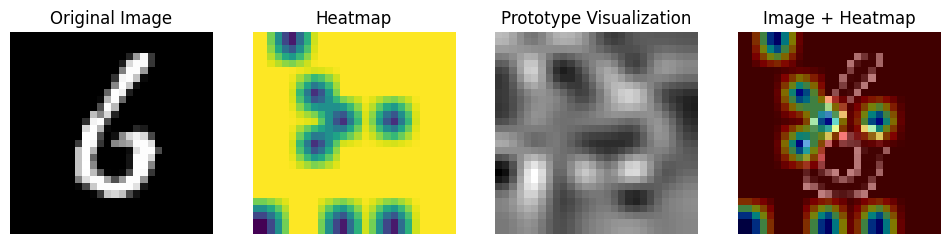

In [62]:
prototype_heatmap(image,image_rep,assigned_proto)

The generated explanation highlights parts of the input image that makes it similar to the protoype corresponding to the predicted class.

## References
[[1] Captum Robustness with Image Classification](https://captum.ai/tutorials/CIFAR_Captum_Robustness)